## Importance analysis and first perforance baselines

## Encoding of all features

In this first iteration of design, we chose to simplify the model as much as possible. That includes dropping samples in case of doubt and not performing advanced feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/SBAnational.csv')
df.head(1)

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_56732/4085732375.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


In [3]:
drop_columns = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank' ,'BankState', 'ApprovalDate', 'ApprovalFY',
                'CreateJob', 'RetainedJob','NoEmp', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr']
df.drop(drop_columns, inplace=True, axis=1)
df.head(1)

,NAICS,Term,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,451120,84,2.0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


### Target
The target will be binary encoded, 1 representing a defaulted loand and 0 the case of full payment.

In [4]:
# Drop data with null MIS_Status, as it is useless
df.dropna(subset=['MIS_Status'], inplace=True)
df['MIS_Status'].describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [5]:
target = 'Default'
# Encode the target variable to binary values. This will encode Default as 1, which in my opinion makes everything more intuitive.
df[target] = np.where(df['MIS_Status'] == 'CHGOFF', 1, 0)
df[target].describe()

# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# df[target] = label_encoder.fit_transform(df['MIS_Status'])
# df.drop(['MIS_Status'], inplace=True, axis=1)
# print(df[target].describe())
# # Paid in Full is encoded as 1

count    897167.000000
mean          0.175617
std           0.380494
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Default, dtype: float64

In [6]:
# Now let's go over all of these columns
df.columns

Index(['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv', 'Default'],
      dtype='object')

### NAICS

As we're keeping things simple in this first iteration, we will only take a look at the first two digits of NAICS, which encode the broad industry.

In [7]:
## Convert NAICS to a string to make easier getting two digits.
df['NAICS'] = df['NAICS'].astype(str)

## Get only first two digits of NAICS, an convert it back to integer.
def NAICS_conversion(naics_string):
    return int(naics_string[:2])

df['NAICS_i'] = df['NAICS'].apply(NAICS_conversion).astype(int)

In [8]:
df['NAICS_i'].value_counts().head(5)

NAICS_i
0     201667
44     84567
81     72395
54     67922
72     67511
Name: count, dtype: int64

In [9]:
# We are going to create an array of features to be considered in the model.
features = ['NAICS_i']

### Term
We will use term in months as a numerical feature

In [10]:
# Term gets directly used as a numerical feature.
features.append('Term')

### NewExist
We will change it to isNewBusiness, which is 1 when the company is of new creation.

In [11]:
# NewExist has samples with value 0.0 and nulls. Let's drop these.
df = df[(df['NewExist'] != 0) & (df['NewExist'].notnull())]

df['NewExist'].value_counts()

NewExist
1.0    643446
2.0    252559
Name: count, dtype: int64

In [12]:
# Make a column called NewBusiness, which is 0 when NewExist is 1 and 1 when it's 2.

df['isNewBusiness'] = df['NewExist'] - 1
df['isNewBusiness'].describe()

count    896005.000000
mean          0.281872
std           0.449912
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: isNewBusiness, dtype: float64

In [13]:
# Gets added as a feature
features.append('isNewBusiness')

### FranchiseCode
For now, we will use it as isFranchise, being 1 when a business is a franchise and 0 otherwise.

In [14]:
# Function to create the 'isFranchise' column
def is_franchise(code):
    return 0 if code in [0, 1] else 1

df['isFranchise'] = df['FranchiseCode'].apply(is_franchise)

In [15]:
df['isFranchise'].describe()

count    896005.000000
mean          0.057647
std           0.233075
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFranchise, dtype: float64

In [16]:
# Gets added to our features
features.append('isFranchise')

### UrbanRural
Each of the three options of UrbanRural (0, 1 and 2) are considered as valid inputs.

In [17]:
df['UrbanRural'] = df['UrbanRural'].astype(str)
df['UrbanRural'].describe()

count     896005
unique         3
top            1
freq      468811
Name: UrbanRural, dtype: object

In [18]:
# Gets added to our features
features.append('UrbanRural')

### RevLineCr
We will reduce it to 1, if it is a Revolving Line of Credit, or 0 otherwise.

In [19]:
df['RevLineCr'].value_counts()

RevLineCr
N    418229
0    257375
Y    200588
T     15232
1        22
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [20]:
# A lot of the possible values are junk. We assume that 0 and N are equivalent and drop the rest of outliers.
df['RevLineCr'] = df['RevLineCr'].replace('N', '0')
df['RevLineCr'] = df['RevLineCr'].replace('0', 0)
df['RevLineCr'] = df['RevLineCr'].replace('Y', 1)

In [21]:
df = df[df['RevLineCr'].isin([0, 1])]
df['RevLineCr'] = df['RevLineCr'].astype(int)

In [22]:
df['RevLineCr'].describe()

count    876192.000000
mean          0.228932
std           0.420145
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: RevLineCr, dtype: float64

In [23]:
# Gets added to our features
features.append('RevLineCr')

### LowDoc
Similarly, will be 1 if the loan is part of the LowDoc program and 0 otherwise.

In [24]:
df['LowDoc'].value_counts()

LowDoc
N    762649
Y    107865
0      1238
C       752
S       599
A       491
R        73
1         1
Name: count, dtype: int64

In [25]:
# All values which are not N or Y get dropped.
df['LowDoc'] = df['LowDoc'].replace('N', 0)
df['LowDoc'] = df['LowDoc'].replace('Y', 1)

In [26]:
df = df[df['LowDoc'].isin([0, 1])]
df['LowDoc'] = df['LowDoc'].astype(int)

In [27]:
df['LowDoc'].describe()

count    870514.000000
mean          0.123910
std           0.329479
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LowDoc, dtype: float64

In [28]:
features.append('LowDoc')

### GrAppv
The size of the loan will be used as a feature after being converted to float numbers.

In [29]:
#Parse dollar values to float value
def dollar_to_float(dollar_string: str):
    return float(dollar_string.replace('$','').replace(',',''))

In [30]:
df['GrAppv'] = df['GrAppv'].apply(dollar_to_float)

In [31]:
df['GrAppv'].describe()

count    8.705140e+05
mean     1.951101e+05
std      2.843112e+05
min      1.000000e+03
25%      3.500000e+04
50%      9.400000e+04
75%      2.300000e+05
max      5.000000e+06
Name: GrAppv, dtype: float64

In [32]:
# Gets added to our features
features.append('GrAppv')

### SBA_Appv (SBARatio)
As SBARatio is a product of GrAppv and SBA_Appv, there is no need in keeping all three. We will stick to SBARatio and GrAppv.

In [33]:
# Convert SBA_Appv to float numbers
df['SBA_Appv'] = df['SBA_Appv'].apply(dollar_to_float)

In [34]:
# Compute the ratio as the division between the two.
df['SBARatio'] = df['SBA_Appv'] / df['GrAppv']

In [35]:
df['SBARatio'].describe()

count    870514.000000
mean          0.711526
std           0.173216
min           0.028140
25%           0.500000
50%           0.750000
75%           0.850000
max           1.000000
Name: SBARatio, dtype: float64

###

In [36]:
# Gets added to our features
features.append('SBARatio')

In [37]:
df[features].describe()

,NAICS_i,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBARatio
count,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,8.705140e+05,870514.000000
mean,39.514401,111.508946,0.282303,0.058415,0.229363,0.123910,1.951101e+05,0.711526
std,26.364679,79.177488,0.450120,0.234526,0.420424,0.329479,2.843112e+05,0.173216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.028140
25%,23.000000,60.000000,0.000000,0.000000,0.000000,0.000000,3.500000e+04,0.500000
50%,44.000000,84.000000,0.000000,0.000000,0.000000,0.000000,9.400000e+04,0.750000
75%,56.000000,120.000000,1.000000,0.000000,0.000000,0.000000,2.300000e+05,0.850000
max,92.000000,569.000000,1.000000,1.000000,1.000000,1.000000,5.000000e+06,1.000000


These are the features used in our first model. As we will use tree-based models, there is no need for normalization. Is important to see that the count is the same in all of them, meaning that we have succesfully got rid of all the nulls and outliers. \
All of them are numerical by now, and some will have to get encoded before our model can be trained.

In [38]:
print(f'Our ratio of target variable is {df[target].mean()} ')
print(f"The baseline performance of a trivial model is {(1-df[target].mean())*100:.2f}%!")

Our ratio of target variable is 0.1714619179013778 
The baseline performance of a trivial model is 82.85%!


This means that a model that always predicted that a loan will not default will result in a performance of almost 83%! If our model performs close to that number it would be considered useless.

In [39]:
# This trivial model always identifies a loan as paid in full. Let's score it.
def trivial_model(X: pd.DataFrame):
    return np.zeros((len(X), 1))

from sklearn.metrics import accuracy_score, f1_score
trivial_acc = accuracy_score(df[target], trivial_model(df[features]))
trivial_f1 = f1_score(df[target], trivial_model(df[features]))

print(f"Our trivial model has {trivial_acc*100:.2f}% accuracy!")
print(f"However, it has {trivial_f1*100:.2f}% F1 score. (0 recall and 0 precision)")


Our trivial model has 82.85% accuracy!
However, it has 0.00% F1 score. (0 recall and 0 precision)


Therefore, accuracy won't be used as a metric. We will prefer others like recall, precision or F1!

## Decision trees for importance analysis

### Encoding

In [40]:
df[features].head(1)

,NAICS_i,Term,isNewBusiness,isFranchise,UrbanRural,RevLineCr,LowDoc,GrAppv,SBARatio
0,45,84,1.0,0,0,0,1,60000.0,0.8


Even though all of our variables seem numerical right now, some of them have to be encoded as they have cathegorical meaning. Specifically, NAICS_i and UrbanRural don't have numerical meaning.

In [41]:
# Encode categorical features. We will use one-hot encoding, as the number of possibilities are manageable.

cat_variables = [
    'NAICS_i',
    'UrbanRural'
]

df_encoded = df[features]

df_encoded = pd.get_dummies(
    data = df_encoded,
    prefix = cat_variables,
    columns = cat_variables
)

df_encoded.head(1)

,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBARatio,NAICS_i_0,NAICS_i_11,NAICS_i_21,...,NAICS_i_56,NAICS_i_61,NAICS_i_62,NAICS_i_71,NAICS_i_72,NAICS_i_81,NAICS_i_92,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,84,1.0,0,0,1,60000.0,0.8,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Using pandas get_dummies, our one-hot encoded features take boolean values instead of integers. It won't matter for tree-based models, but if we were to train a neural network or regression model this would be problematic.\
In that case, we will use scikit-learn's one-hot encoder.

### Splitting

In [42]:
# Let's choose out definitive list of encoded features!
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
print(features_encoded)

['Term', 'isNewBusiness', 'isFranchise', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
# 75% will be for training. 12.5% for cross-validation and hyperparameter tuning and 12.5% for model evaluation.
X_train, X_, y_train, y_ = train_test_split(df_encoded[features_encoded], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")

X -- Train shape: (652885, 35), CV: (108814, 35), test: (108815, 35)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


### Single decision tree
For explainability purposes, and to be able to extract feature importances, we will start by training a single decision tree. Keep in mind that the objective of this model is to offer some insight on which features are having a bigger impact in our model, and not to make real predictions.\
Therefore, we will tune hyperparameters by hand, and plot the training and cross-validation evaluations for each hyperparameter.\
In this way, we will obtain:
1. A representation of which hyperparameters are more promissing for our later models.
2. Information regarding the weight of features in our target distribution.
3. A way to promtly detect high bias or high variance in our model.

In [45]:
# Choose hyperparameters to be tried. We will tune by hand the minimum number of samples in a leaf to do another split and the maximum depth
# to which the tree can reach.

min_samples_list = [20, 50, 100, 200, 500, 1000, 10000]
max_depths_list = [1,2, 3, 4, 8, 16, 32, 64, None]

Optimum minimum samples to split is 200. CV Recall: 0.8263217097862767


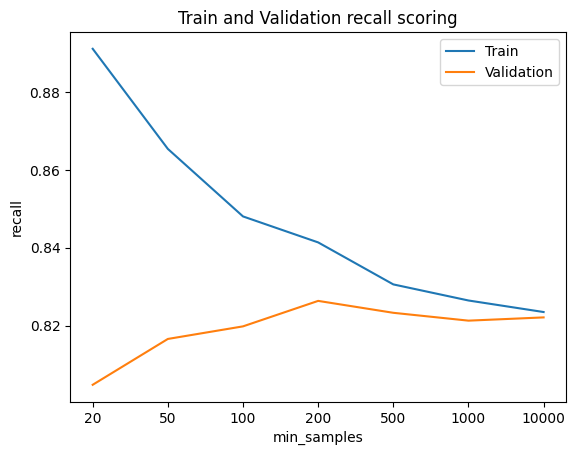

In [46]:
# Recall score will be used as a metric, as the cost of false negatives (defaulted loans which we fail to detect) is
# higher than that of false positives (paid in full loans we flag as default). 

from sklearn.tree import DecisionTreeClassifier # Single tree
from sklearn.metrics import recall_score

# Recall array for latter plotting.
recalls = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for min_sample in min_samples_list:

    # Train a model for each one.
    model = DecisionTreeClassifier(min_samples_split=min_sample).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    # Append the score to the recalls array.
    recalls["train"].append(recall_score(yhat_train, y_train))
    recalls["cv"].append(recall_score(yhat_cv, y_cv))

optimum_min_samples = min_samples_list[np.argmax(recalls['cv'])]
print(f"Optimum minimum samples to split is {optimum_min_samples}. CV Recall: {np.max(recalls['cv'])}")

plt.title('Train and Validation recall scoring')
plt.xlabel('min_samples')
plt.ylabel('recall')
plt.xticks(ticks = range(len(min_samples_list )),labels=min_samples_list)
plt.plot(recalls["train"])
plt.plot(recalls["cv"])
plt.legend(['Train','Validation'])

It is possible to see how a smaller minimum of samples to split gets good train recall toguether with bad validation recall. That's overfitting, or high variance! In our optimum, we get a better variance, with both train and cv performing similarly good. That means that our model generalizes quite well to new data.

Optimum maximum depth to stop is 16. CV Recall: 0.8145790668068855


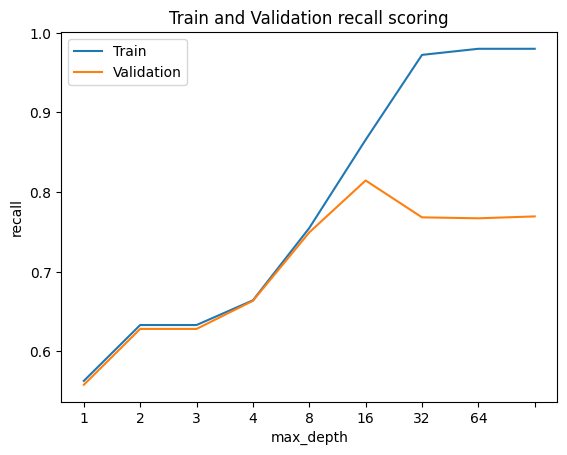

In [47]:
# Recall array for latter plotting.
recalls = {
    "train": [],
    "cv": []
}

# Iterate over the max depths list.
for max_depth in max_depths_list:
    
    model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    recalls["train"].append(recall_score(yhat_train, y_train))
    recalls["cv"].append(recall_score(yhat_cv, y_cv))

optimimum_max_depth = max_depths_list[np.argmax(recalls['cv'])]

print(f"Optimum maximum depth to stop is {optimimum_max_depth}. CV Recall: {np.max(recalls['cv'])}")

plt.title('Train and Validation recall scoring')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.xticks(ticks = range(len(max_depths_list)),labels=max_depths_list)
plt.plot(recalls["train"])
plt.plot(recalls["cv"])
plt.legend(['Train','Validation'])


Similarly, if the depth of the tree is very big or unlimited, the model overfits. In our optimal, the model performs good with unseen data.

In [48]:
# Now let's pick both of these together and train a model!
dtmodel = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train, y_train)

### Feature importance

<class 'numpy.ndarray'>


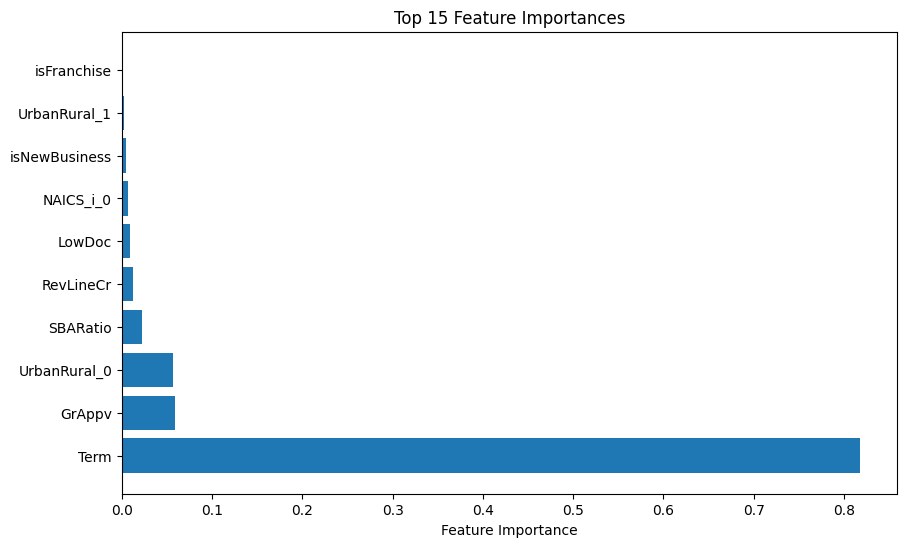

In [49]:
# Get feature importances from the trained model
importances = dtmodel.feature_importances_

# Get indices of top 15 importances
top_indices = np.argsort(importances)[::-1][:10]
print(type(top_indices))
top_importances = importances[top_indices]
top_feature_names = np.array(features_encoded)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.show()

Here we can see that our model is mainly taking into account the term of the loan. As we discovered during exploration, shorter term loans are way more likely to default.

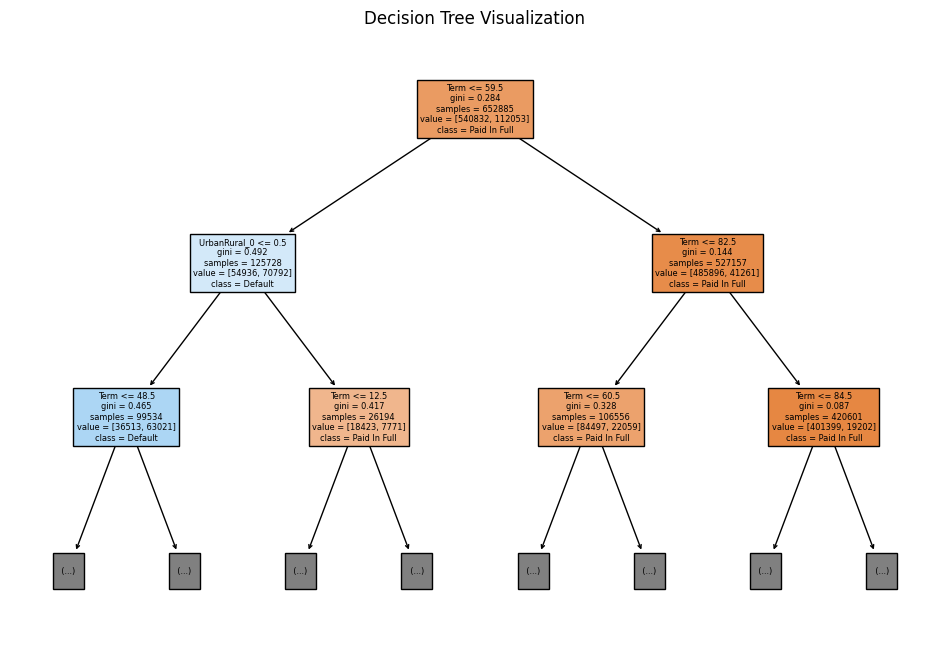

In [50]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(dtmodel, filled=True, feature_names=features_encoded, class_names=['Paid In Full', 'Default'], max_depth=2)
plt.title("Decision Tree Visualization")
plt.show()

## Scoring of the single tree. Confusion matrixes.
To get a valuable score of our first tree, we will score it against totally unseen data, our X_test set. It has never been used yet, not even for picking hyperparameters. In this way we can see how our model would perform with totally new samples.

In [51]:
yhat_test = dtmodel.predict(X_test)

In [52]:
test_recall = recall_score(yhat_test, y_test)
print(f"Our model has a test recall of {test_recall*100:.2f}%!")

Our model has a test recall of 82.58%!


That's great! It is in line with both train and cross-validation recalls, meaning that our model is not overfitting. Now let's draw the test confusion matrix.

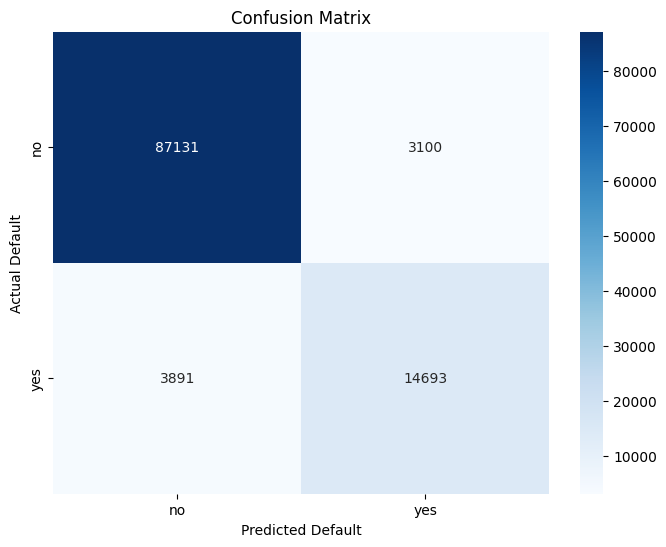

In [53]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, yhat_test)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()


That is actually quite good! We are spotting most of the defaults. However, we can perform even better in latter models.\
 And for our whole data:

Overall recall 0.8361714414490549


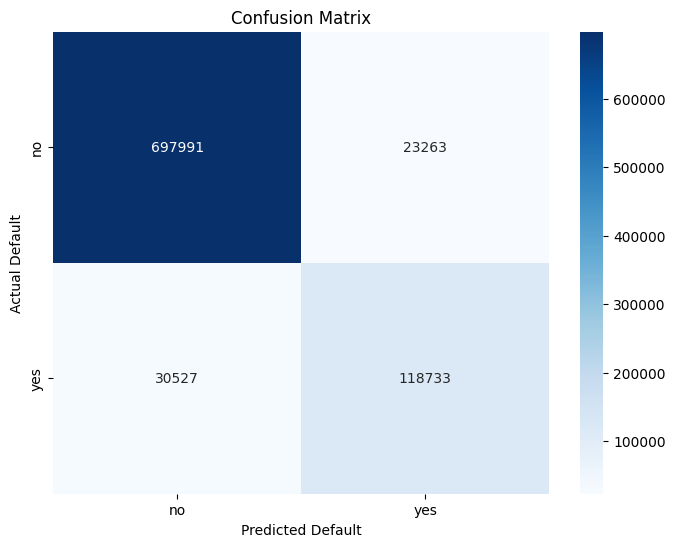

In [54]:
# Calculate the confusion matrix
yhat_total = dtmodel.predict(df_encoded[features_encoded])
cm = confusion_matrix(df[target], yhat_total)

print(f"Overall recall {recall_score(yhat_total, df[target])}")
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()

This is the confusion matrix of our first simple model in all the filtered data, a single decision tree. From now onwards, taking this as a baseline performance we will be more agressive in the hyperparameter optimization.\
We will also try other encodings of features, and feature engineer new ones to be as good as we can.

In [55]:
# Obtain a dataframe that includes the features and the target
# Indexes need to be reseted so that the concatenation makes sense.
df_encoded_reset = df_encoded[features_encoded].reset_index(drop=True)
df_target_reset = df[target].reset_index(drop=True)

# Concatenating along columns axis
df_out = pd.concat([df_encoded_reset, df_target_reset], axis=1)
df_out.describe()

,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBARatio,Default
count,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,8.705140e+05,870514.000000,870514.000000
mean,111.508946,0.282303,0.058415,0.229363,0.123910,1.951101e+05,0.711526,0.171462
std,79.177488,0.450120,0.234526,0.420424,0.329479,2.843112e+05,0.173216,0.376912
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.028140,0.000000
25%,60.000000,0.000000,0.000000,0.000000,0.000000,3.500000e+04,0.500000,0.000000
50%,84.000000,0.000000,0.000000,0.000000,0.000000,9.400000e+04,0.750000,0.000000
75%,120.000000,1.000000,0.000000,0.000000,0.000000,2.300000e+05,0.850000,0.000000
max,569.000000,1.000000,1.000000,1.000000,1.000000,5.000000e+06,1.000000,1.000000


In [58]:
df_out.to_csv('../data/df_encoded.csv', index=False)

In [57]:
df_out.head()

,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBARatio,NAICS_i_0,NAICS_i_11,NAICS_i_21,...,NAICS_i_61,NAICS_i_62,NAICS_i_71,NAICS_i_72,NAICS_i_81,NAICS_i_92,UrbanRural_0,UrbanRural_1,UrbanRural_2,Default
0,84,1.0,0,0,1,60000.0,0.80,False,False,False,...,False,False,False,False,False,False,True,False,False,0
1,60,1.0,0,0,1,40000.0,0.80,False,False,False,...,False,False,False,True,False,False,True,False,False,0
2,180,0.0,0,0,0,287000.0,0.75,False,False,False,...,False,True,False,False,False,False,True,False,False,0
3,60,0.0,0,0,1,35000.0,0.80,True,False,False,...,False,False,False,False,False,False,True,False,False,0
4,240,0.0,0,0,0,229000.0,1.00,True,False,False,...,False,False,False,False,False,False,True,False,False,0
